## Classifying Star and Galaxy Images 

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
from PIL import Image
import torchvision
import os
from sklearn import model_selection 
import time
import tensorflow as tf
 
from tensorflow.python.client import device_lib


The dataset is a star-galaxy image dataset gathered from a 1.3m telescope of the observatory in Devastal, Nainital, India. The dataset could be found on Kaggle. The images are a 64x64 cutout with there being 3044 images of stars and 942 images being of galaxys. 
https://www.kaggle.com/datasets/divyansh22/dummy-astronomy-data

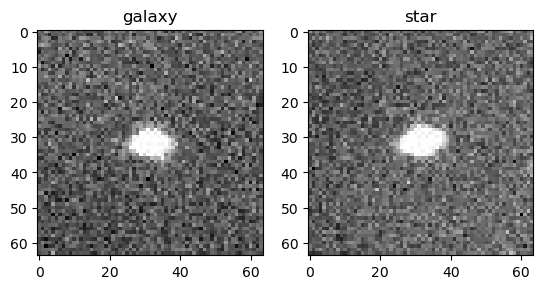

In [2]:
image_1 = Image.open(r'C:\Users\acerb\phys152\archive\Cutout Files\galaxy\grb0422a_01_257_154_3.jpg',"r") 
image_2 = Image.open(r"C:\Users\acerb\phys152\archive\Cutout Files\star\grb0422a_01_68_1020_6.jpg","r")  
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.imshow(image_1)
ax1.imshow(image_1)
ax1.set_title("galaxy")
plt.imshow(image_2)
ax2.imshow(image_2)
ax2.set_title("star")
plt.show()


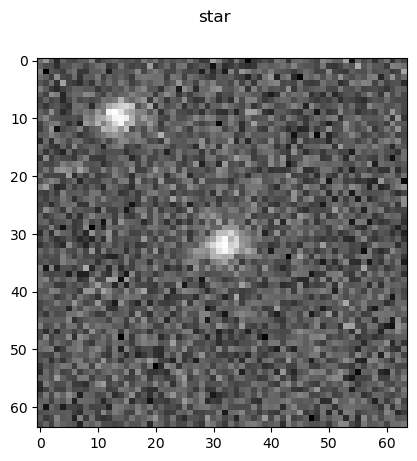

In [70]:
image_3 = Image.open(r"C:\Users\acerb\phys152\archive\Cutout Files\star\grb0422a_01_149_1105_6.jpg", "r")
plt.imshow(image_3)
plt.suptitle("star")
plt.show()

Easier to tell that this image is of a star compared to the previous one.

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.config.list_physical_devices('GPU')
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.is_available()


Num GPUs Available:  1
cuda


True

In [3]:

star_directory = r'C:\Users\acerb\phys152\archive\Cutout Files\star'
files = os.listdir(star_directory)
index = 0
star = []
star_labels = []
while index < len(files):
    star_filename = files[index]
    if star_filename.endswith('.jpg'):
        with Image.open(os.path.join(star_directory, star_filename)) as f:
            grayscaleimage=torchvision.transforms.Grayscale()(f) #Converting the image to a gray scale image because that way there are less filters that we have to deal with
            grayscaleimagetensor=torchvision.transforms.functional.to_tensor(grayscaleimage)
            star.append(grayscaleimagetensor)
            #Setting the label of stars as 0
            star_labels.append(0)

    index += 1

galaxy_directory = r'C:\Users\acerb\phys152\archive\Cutout Files\galaxy'
files = os.listdir(galaxy_directory)
index = 0
galaxy = []
galaxy_labels = []
while index < len(files):
    galaxy_filename = files[index]
    if galaxy_filename.endswith('.jpg'):
        with Image.open(os.path.join(galaxy_directory, galaxy_filename)) as f:
            grayscaleimage=torchvision.transforms.Grayscale()(f)
            grayscaleimagetensor=torchvision.transforms.functional.to_tensor(grayscaleimage)
            galaxy.append(grayscaleimagetensor)
            #Setting the galaxy labels as 1
            galaxy_labels.append(1)
           

    index += 1


print(len(star))
print(len(galaxy))

3044
942


## Sorting the Data
Storing all the galaxy and star tensors into into Alldata while also storing the star labels and galaxy labels into all_labels. Using torch.stack() takes the list of tensors stored in Alldata and condenses down into a new dimension. Turing all_labels into a tensor lets me able to make training data where 25% about 997 of my total data is being used as test data. 

In [106]:
#galaxy = torch.load('galaxytensor.pt')
#star = torch.load('startensor.pt')

print(star[0])
Alldata = star + galaxy # Combining all the star and galaxy tensors 
all_labels = star_labels + galaxy_labels # Combining star lables [0] and galaxy lables [1]
Alldata = torch.stack(Alldata)
print(Alldata.size()) # 3986 data points with 1 array of 64x64
all_labels = torch.tensor(all_labels)
print(all_labels.size()) 


x_train, x_test, y_train, y_test = model_selection.train_test_split(Alldata, all_labels, test_size=0.25, random_state=123)
xy_train = torch.utils.data.TensorDataset(x_train.float(),y_train)
x_test = x_test.to(device)

tensor([[[0.4980, 0.2549, 0.4510,  ..., 0.2510, 0.2588, 0.4980],
         [0.4745, 0.4118, 0.5725,  ..., 0.2314, 0.4667, 0.5020],
         [0.2314, 0.2196, 0.4863,  ..., 0.4078, 0.0078, 0.0902],
         ...,
         [0.2314, 0.5137, 0.3608,  ..., 0.3059, 0.2000, 0.2549],
         [0.2431, 0.1137, 0.4471,  ..., 0.4588, 0.2784, 0.4000],
         [0.1804, 0.4431, 0.4392,  ..., 0.0471, 0.4039, 0.3882]]])
torch.Size([3986, 1, 64, 64])
torch.Size([3986])


## Making the Model

A CNN is a type of neural network that is strong in image processing and as Gosh puts it “They are ideal for galaxy morphology classification as they do not require selection of morphological proxies by hand and the network itself decides on which features of the image best discriminate among the different classes” [1]. A CNN like most other neural networks is made up of an input layer, a hidden layer, and the output layer. The hidden layer is where the important layers are, being made up of a convolutional layer, activation layer, pooling layer, and the fully connected layers [2,3]. The convolutional layer is the most important layer where a kernel filters the image in a 2x2, 3x3, or a 5x5 matrix [3]. There are different ways to implement the kernels which are sparse interactions, parameter sharing, and equivariance [4]. The activation layer uses the common activation functions like RELU or tanh. The pooling layer downsizes the output of the network which helps reduce the dimensionality which helps improve the networks efficiency [3]. The two types of pooling that can be done, max pooling takes the max of a sample and average pooling which takes an average value of a sample [3,4]. The fully connected layer connects all the previous layers to an activations unit to make a final
classification decision [3]. A common problem with models is that sometimes the model can over overfit data. One solution to this problem is to add dropout to the layers in the network. Dropout is where values whether "hidden or visable" gets dropped out depending on a probability p [5].

In [107]:
torch.manual_seed(123)
class Net(torch.nn.Module):
    def __init__(self, conv_layer_size=32, linear_layer_size=64):
        super(Net, self).__init__()

        lls=linear_layer_size
        cls=conv_layer_size

        # two convolutional layers
        self.conv1 = torch.nn.Conv2d(  1, cls, kernel_size=2, padding=1)
        self.conv2 = torch.nn.Conv2d(cls, lls, kernel_size=2, padding=1)
        

        # fully connected layer
        self.fc1 = torch.nn.Linear(lls,cls )
        self.fc2 = torch.nn.Linear(cls,2)

        
        #Added batches to help improve the overtraining of the data
        self.bn1 = torch.nn.BatchNorm2d(cls)
        self.bn2 = torch.nn.BatchNorm2d(lls)
        
        #Added dropout to help improve the overfitting
        self.dropout = torch.nn.Dropout(0.50)
    # x represents our data
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x) 
        #x = torch.sigmoid(x)


        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)


        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = torch.sigmoid(x)
        #x = torch.nn.ReLU(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)

 
        # the (1,1) makes this into global average pooling
        x = F.adaptive_avg_pool2d(x,(1,1))
        x=torch.flatten(x,1)

        # Pass data through the fully connected layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        #x = torch.sigmoid(x)
        x = self.fc2(x)
        return x


## Training the Model

In [108]:
net = Net().to(device)
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(x_train)/5), shuffle=True)

In [109]:
losses = []
losses_test = []
for epoch in range(40):
    start_time = time.time()
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = net(x_batch)
        y_batch = F.one_hot(y_batch, num_classes=2).float().to(device)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test)
    y_test_onehot = F.one_hot(y_test, num_classes=2).float().to(device)
    test_loss=loss_fn(y_pred, y_test_onehot)
    losses_test.append(test_loss.data)
    end_time=time.time()
    
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.4s, Train loss=4.7e-01, Test loss=4.4e-01
Completed epoch  1 in  0.4s, Train loss=4.4e-01, Test loss=4.4e-01
Completed epoch  2 in  0.2s, Train loss=4.3e-01, Test loss=4.3e-01
Completed epoch  3 in  0.4s, Train loss=4.3e-01, Test loss=4.3e-01
Completed epoch  4 in  0.2s, Train loss=4.3e-01, Test loss=4.3e-01
Completed epoch  5 in  0.4s, Train loss=4.3e-01, Test loss=4.3e-01
Completed epoch  6 in  0.2s, Train loss=4.3e-01, Test loss=4.3e-01
Completed epoch  7 in  0.4s, Train loss=4.3e-01, Test loss=4.3e-01
Completed epoch  8 in  0.2s, Train loss=4.3e-01, Test loss=4.3e-01
Completed epoch  9 in  0.4s, Train loss=4.2e-01, Test loss=4.2e-01
Completed epoch 10 in  0.2s, Train loss=4.3e-01, Test loss=4.2e-01
Completed epoch 11 in  0.4s, Train loss=4.2e-01, Test loss=4.2e-01
Completed epoch 12 in  0.2s, Train loss=4.2e-01, Test loss=4.2e-01
Completed epoch 13 in  0.4s, Train loss=4.2e-01, Test loss=4.2e-01
Completed epoch 14 in  0.2s, Train loss=4.2e-01, Test loss=4.2

## Plotting the Loss

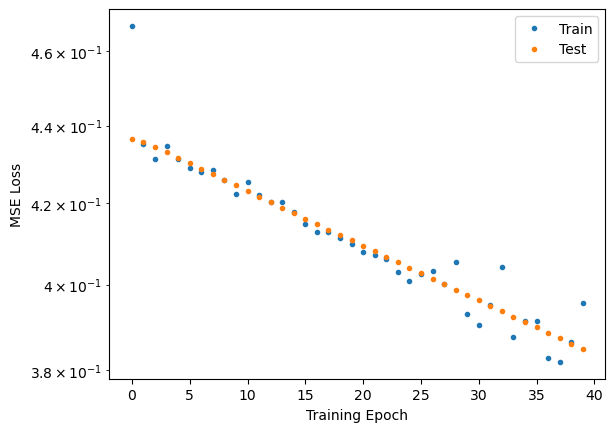

In [110]:
#Converting data from the GPU to CPU data
losses_train_np = []
for loss in losses:
    losses_train_np.append(loss.cpu().numpy())
losses_test_np = []
for loss in losses_test:
    losses_test_np.append(loss.cpu().numpy())

plt.plot(losses_train_np, '.', label="Train")
plt.plot(losses_test_np, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

In [99]:
def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

In [113]:
y_test_np = []
for y in y_test_onehot:
    y_test_np.append(y.cpu().numpy())
y_pred_np = []
for y in y_pred:
    y_pred_np.append(y.cpu().detach().numpy())

a =acc(y_test_np, y_pred_np)
a = a*100
a = round(a)
print("accuracy: " + str(a) + "%" )

accuracy: 75%


## Refrences

1. Ghosh, A., Urry, C. M., Wang, Z., Schawinski, K., Turp, D., & Powell, M. C. (2020).
Galaxy Morphology Network: a convolutional neural network used to study morphology
and quenching in ∼100,000 SDSS and ∼20,000 CANDELS galaxies. The Astrophysical
Journal, 895(2), 112. https://doi.org/10.3847/1538-4357/ab8a47
2. GfG. (2023b, December 20). Introduction to Convolution Neural Network.
GeeksforGeeks. https://www.geeksforgeeks.org/introduction-convolution-neural-
network/
3. Craig, L., & Awati, R. (2024, January 11). convolutional neural network (CNN).
Enterprise AI. https://www.techtarget.com/searchenterpriseai/definition/convolutional-
neural-network
4. Hance, M. (2024, February 16). CNNs [Lecture notes]. University of California
Santa Cruz
5. Brownlee, J. (2019, August 6). A gentle introduction to dropout for regularizing deep neural networks. MachineLearningMastery.com. https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
6. Star-Galaxy classification data. (2021, June 12). Kaggle.
https://www.kaggle.com/datasets/divyansh22/dummy-astronomy-data
